<a href="https://colab.research.google.com/github/GrzegorzAndrzejczak/Programowanie-w-Pythonie/blob/main/CASE_lighthouse_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dane: lighthouse.csv
### 2. MCMC - wg emcee

#### StrechMove

Koncepcja **StretchMove** zakłada afiniczne modyfikacje w przestrzeni próbek - w kierunku zależnym od poprzedniego ogniwa łańcucha (**_bez dowodu!_**).
Pochodzi z pracy:

    A Goodman & Weare (2010)
    <https://msp.org/camcos/2010/5-1/p04.xhtml> "stretch move" with
    parallelization as described in Foreman-Mackey et al. (2013)
    <https://arxiv.org/abs/1202.3665>.
>czyli:

COMM. APP. MATH. AND COMP. SCI.
Vol. 5, No. 1, 2010   
ENSEMBLE SAMPLERS WITH AFFINE INVARIANCE  
JONATHAN GOODMAN AND JONATHAN WEARE

>i

**emcee:** The MCMC Hammer   
Daniel Foreman-Mackey, David W. Hogg, Dustin Lang, Jonathan Goodman

Przy okazji -- pora na zmianę podejścia do parametrów...

In [1]:
import warnings
def log_prior(ab):
    where = ab[:, 1]<0
    ab[where, 1] = 0
    return -ab[:, 1]**(-1)

def log_likelihood(ab, Data):
    where = ab[:, 1]<0
    ab[where,1] = 0
    return -np.sum(np.log((Data - ab[:,0])**2 + ab[:,1]**2)-np.log(ab[:,1]), axis=0)

def log_posterior(ab, Data):
    warnings.simplefilter("ignore")
    return log_prior(ab) + log_likelihood(ab, Data)

def compute_log_prob(coords):
    return log_posterior(coords, D)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

d = pd.read_csv('sample_data/lighthouse.csv')
N = 5  # number of measurements
D = d.values[:N]

ndim = 2  # number of parameters in the model
nwalkers = 10000  # number of MCMC walkers
nburn = 100  # "burn-in" period to let chains stabilize
nsteps = 300  # number of MCMC steps to take - czyli zostaje 100:300

# we'll start at random locations
starting_guesses = np.random.rand(nwalkers, ndim)*10


In [ ]:

def get_proposal(sampl, complement, random):       # wg. StretchMove
    complement = np.concatenate(complement, axis=0)
    Ns, Nc = len(sampl), len(complement)
    ndim_ = sampl.shape[1]              # a = 2.0
    zz = (random.rand(Ns) + 1)**2 /2    # ((a - 1.0) * random.rand(Ns) + 1) ** 2.0 /a  \in  [1/a,a]
    factors = (ndim_ - 1.0) * np.log(zz)
    rint = random.randint(Nc, size=(Ns,))
    return complement[rint] - (complement[rint] - sampl) * zz[:, None], factors

# propose wg Move.update()
def update(old_state, new_state, accepted_, subset=None):
    """Update a given subset of the ensemble with an accepted proposal """
    if subset is None:
        subset = np.ones(len(old_state.coords), dtype=bool)
    m1 = subset & accepted_
    m2 = accepted_[subset]
    old_state.coords[m1] = new_state.coords[m2]
    old_state.log_prob[m1] = new_state.log_prob[m2]
    return old_state

_random = np.random.RandomState(42)   # for repeatability
random_state = _random.__getstate__()


Konstrukcja użyta w **emcee** korzysta z dwu klas typu *namedtuple*:

In [ ]:
from collections import namedtuple
from copy import deepcopy
from time import time_ns

Model = namedtuple(
    "Model", ("compute_log_prob_fn", "map_fn", "random")
)
model = Model(compute_log_prob, map, _random)
State = namedtuple(
    "State", ("coords", "log_prob", "random_state")
)
state = State(deepcopy(starting_guesses), compute_log_prob(starting_guesses), random_state)


In [ ]:
# nwalkers = 10000
# nsteps = 500
chain = np.empty((nsteps, nwalkers, ndim), dtype=np.float32)
              # zmiana kolejności - w stos. do emcee
t0=time_ns()
for i in range(nsteps):
    # propose wg RedBlueMove.propose(self, model, state):
    # Split the ensemble in 100/or halves and iterate over these parts.
    nsplits = 2; randomize_split = True
    accepted = np.zeros(nwalkers, dtype=bool)
    all_inds = np.arange(nwalkers)
    inds = all_inds % nsplits
    if randomize_split:
        model.random.shuffle(inds)
    for split in range(nsplits):            # Get the two halves of the ensemble.
        S1 = inds == split
        sets = [state.coords[inds == j] for j in range(nsplits)]    # state się zmienia!
        s = sets[split]         # (30,1)
        c = sets[:split] + sets[split + 1:]     # lisa, c[0].shape = (30, 1)

        # Get the move-specific proposal.
        q, factors = get_proposal(s, c, model.random)

        # Compute the lnprobs of the proposed position.
        new_log_probs = model.compute_log_prob_fn(q)

        # Loop over the walkers and update them accordingly.
        for _, (j, f, nlp) in enumerate(
                zip(all_inds[S1], factors, new_log_probs)
        ):
            lnpdiff = f + nlp - state.log_prob[j]
            if lnpdiff > np.log(model.random.rand()):   # <------
                accepted[j] = True

        new_state = State(q, new_log_probs, model.random)

        state = update(state, new_state, accepted, S1)
        chain[i] = state.coords
t1=time_ns()
print(f'time={(t1-t0)/10**9:5.1f}')


time= 11.2


Wizualizacja:

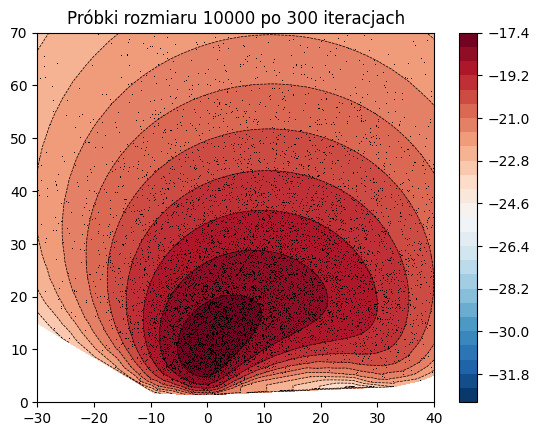

array([ 8.723445, 28.007812], dtype=float32)

In [ ]:
# nburn = 100
# sample = chain[nburn:,:, :].reshape(-1,2)   # (50000,2) zamiast (50,1000,2)
sample = chain[-1]  #-------!!!!!!!!!!
sample_ = sample
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
# ax.scatter(*sample.T, s=.03)      # albo
ax.plot(*sample_.T, ",k")
logR = compute_log_prob(sample_)
ax.tricontour(*sample_.T, logR, levels=25, linewidths=0.5, colors='k');
cntr2 = ax.tricontourf(*sample_.T, logR, levels=25, cmap="RdBu_r");
fig.colorbar(cntr2, ax=ax)
ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.set_title(f"Próbki rozmiaru {nwalkers} po {nsteps} iteracjach")
plt.show(block=False)
sample_.mean(axis=0)    # 50000?:[ 8.288431, 28.831856]


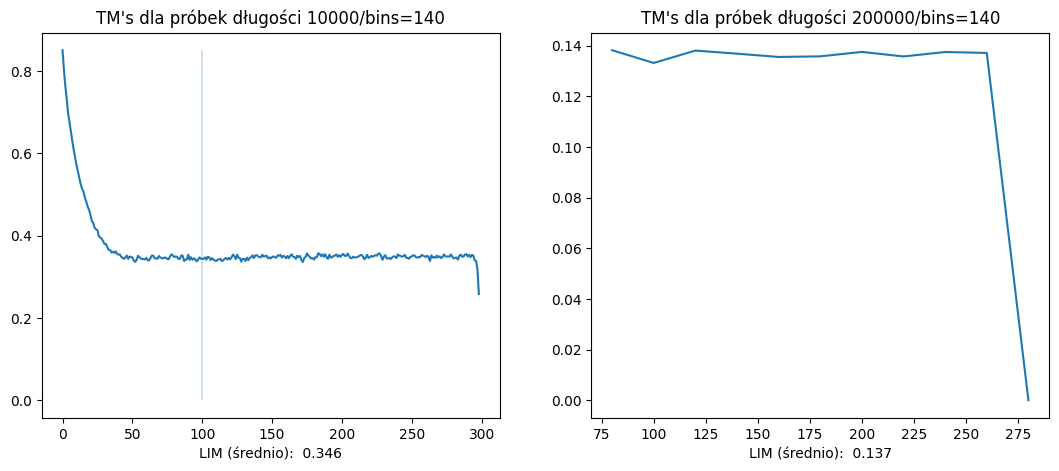

In [ ]:
# czas na ocenę TM-dist...
bins = 140
Hb, xb, yb = np.histogram2d(*sample.T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
lastN = nsteps
n_rang = np.arange(lastN)
tm_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):    # * 100:
    path_ = chain[k].T  #-------!!!!!!!!!!
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tm_ = np.abs(H_ - Hb).sum()/2
    # print(f'{k:4}: {tm_:6.3f}')
    tm_vals[i] = tm_
tm_vals *= (140/bins)**2   # podział na 100^2 zamiast 140^2
fig, (ax0, ax) = plt.subplots(1,2,figsize=(13,5))
ax0.plot(n_rang[:-1], tm_vals[:-1])
ax0.vlines(nburn, 0, tm_vals[0],lw=.3)
ax0.set_title(f"TM's dla próbek długości {nwalkers}/bins={bins}");
ax0.set_xlabel(f"LIM (średnio): {tm_vals[nburn-10:nburn+60].mean():6.3f}");    # 100: 0.174,  140: 0.232

nburn = 80
sample = chain[nburn:].reshape(-1,200000,2)
sample_ = sample[-1]
Hb, xb, yb = np.histogram2d(*sample[-1].T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
lastN = sample.shape[0]
n_rang = np.arange(lastN)
tm_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):    # * 100:
    path_ = sample[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tm_ = np.abs(H_ - Hb).sum()/2
    # print(f'{k:4}: {tm_:6.3f}')
    tm_vals[i] = tm_
tm_vals *= (140/bins)**2   # podział na 100^2 zamiast 140^2
ax.plot(nburn+n_rang*20, tm_vals)
# ax.vlines(nburn, 0, tm_vals[0],lw=.3)
ax.set_title(f"TM's dla próbek długości {sample.shape[1]}/bins={bins}");
# ax.set_title(f"TM's dla próbek długości {20*nwalkers}/bins={bins}");
ax.set_xlabel(f"LIM (średnio): {tm_vals[:-1].mean():6.3f}");    # 100: 0.174,  140: 0.232


### A teraz spróbujmy zbadać, co wnosi **emcee** - w standardowym wydaniu

Zamiast
>import emcee

zasymulujemy istotny fragment kodu z pakietu, by uzyskać efekt oczekiwany od instrukcji:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
    sampler.run_mcmc(starting_guesses, nsteps)

    sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
    sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)



In [ ]:
def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])

t0=time_ns()
sampler.run_mcmc(starting_guesses, nsteps)
t1=time_ns()
print(f'time={(t1-t0)/10**9:5.1f}')

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
# plot_MCMC_results(xdata, ydata, emcee_trace)